In [2]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA  # Optional, but can be very useful
import matplotlib.pyplot as plt


class CNN(nn.Module):
    """
    A simple CNN model for 1x28x28 input.
    """

    def __init__(self, in_c=1, conv1_c=20, conv2_c=15, out_dim=10, input_size=28):
        super().__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(
                in_channels=in_c, out_channels=conv1_c, kernel_size=7, padding=0
            ),  # 28x28 -> 22x22
            nn.BatchNorm2d(conv1_c),
            nn.GELU(),
            nn.Dropout2d(p=0.25),
            # Block 2
            nn.Conv2d(
                in_channels=conv1_c, out_channels=conv2_c, kernel_size=3, padding=0
            ),  # 22x22 -> 20x20
            nn.BatchNorm2d(conv2_c),
            nn.GELU(),
        )

        with torch.no_grad():
            dummy_input = torch.zeros(1, in_c, input_size, input_size)
            dummy_output = self.features(dummy_input)
            self._flattened_size = dummy_output.numel()

        self.flatten = nn.Flatten()
        self.head = nn.Sequential(
            nn.Dropout(p=0.35),
            nn.Linear(self._flattened_size, out_dim),
        )

    def forward_features(self, x):
        x = self.features(x)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.flatten(x)
        x = self.head(x)
        return x

In [7]:
# --- Analysis Configuration ---
NUM_CLASSES = 10  # For MNIST
# How many samples to use for clustering. More samples give more stable results but take longer.
NUM_SAMPLES_FOR_CLUSTERING = 1000
BATCH_SIZE = 128  # Dataloader batch size
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
APPLY_PCA = True  # Whether to apply PCA for dimensionality reduction before clustering
PCA_COMPONENTS = 50  # Number of components for PCA, if applied

print(f"Using device: {DEVICE}")
print(f"Number of samples for clustering analysis: {NUM_SAMPLES_FOR_CLUSTERING}")
print(f"Applying PCA: {APPLY_PCA}, with {PCA_COMPONENTS} components if features allow.")

# --- Data Loading (MNIST) ---
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),  # MNIST specific mean and std
    ]
)

# Use training data for feature analysis
full_train_dataset = datasets.MNIST(
    "../data", train=True, download=False, transform=transform
)

# Create a subset of the dataset for faster analysis
if len(full_train_dataset) < NUM_SAMPLES_FOR_CLUSTERING:
    print(
        f"Warning: Requested {NUM_SAMPLES_FOR_CLUSTERING} samples, but dataset only has {len(full_train_dataset)}."
    )
    num_to_use = len(full_train_dataset)
else:
    num_to_use = NUM_SAMPLES_FOR_CLUSTERING

# Ensure we get diverse samples by shuffling indices first
subset_indices = torch.randperm(len(full_train_dataset))[:num_to_use]
analysis_dataset = Subset(full_train_dataset, subset_indices)

analysis_dataloader = DataLoader(
    analysis_dataset, batch_size=BATCH_SIZE, shuffle=False
)  # Shuffle False to keep order if needed

# --- Model Instantiation ---
model = CNN(in_c=1, conv1_c=20, conv2_c=15, out_dim=NUM_CLASSES, input_size=28).to(
    DEVICE
)
model.eval()  # Set model to evaluation mode

# --- Feature Extraction with Hooks ---
feature_outputs = {}  # Dictionary to store outputs
hook_handles = []  # To store hook handles for later removal


def get_features_hook(layer_name):
    def hook(module, input, output):
        # Detach from graph, move to CPU, convert to numpy
        feature_outputs[layer_name].append(output.detach().cpu())

    return hook


# Identify convolutional layers and attach hooks
conv_layer_names = []
target_modules = []

# Iterate through the `features` sequential block
for name, module in model.features.named_children():
    if isinstance(module, nn.Conv2d):
        layer_id = f"features.{name}_Conv2d_out_channels_{module.out_channels}"
        conv_layer_names.append(layer_id)
        target_modules.append(module)
        feature_outputs[layer_id] = []  # Initialize list for this layer's outputs
        handle = module.register_forward_hook(get_features_hook(layer_id))
        hook_handles.append(handle)

print(f"\nRegistered hooks for layers: {conv_layer_names}")

# --- Data Propagation and Feature Collection ---
all_true_labels = []
print(f"\nExtracting features from {len(analysis_dataset)} samples...")

with torch.no_grad():
    for data, targets in analysis_dataloader:
        data = data.to(DEVICE)
        _ = model(data)  # Forward pass to trigger hooks
        all_true_labels.append(targets.cpu().numpy())

# Concatenate features and labels from all batches
for layer_name in conv_layer_names:
    if feature_outputs[layer_name]:  # Check if any features were captured
        feature_outputs[layer_name] = torch.cat(
            feature_outputs[layer_name], dim=0
        ).numpy()
    else:
        print(f"Warning: No features captured for layer {layer_name}.")
        # Remove this layer from further processing if no features
        conv_layer_names.remove(layer_name)


all_true_labels = np.concatenate(all_true_labels, axis=0)

# Remove hooks
for handle in hook_handles:
    handle.remove()
print("Hooks removed.")

Using device: cpu
Number of samples for clustering analysis: 1000
Applying PCA: True, with 50 components if features allow.

Registered hooks for layers: ['features.0_Conv2d_out_channels_20', 'features.4_Conv2d_out_channels_15']

Extracting features from 1000 samples...
Hooks removed.


In [8]:
# --- Clustering and Evaluation ---
ari_scores = []
layer_names_for_plot = []

print("\n--- Clustering Analysis ---")
for layer_name in conv_layer_names:
    if layer_name not in feature_outputs or feature_outputs[layer_name].size == 0:
        print(f"Skipping layer {layer_name} due to no features.")
        continue

    print(f"\nProcessing layer: {layer_name}")
    layer_features = feature_outputs[layer_name]  # (num_samples, C, H, W)

    # Reshape for clustering: (num_samples, C*H*W)
    num_samples = layer_features.shape[0]
    flattened_features = layer_features.reshape(num_samples, -1)
    print(f"  Original features shape: {layer_features.shape}")
    print(f"  Flattened features shape: {flattened_features.shape}")

    if flattened_features.shape[0] < NUM_CLASSES:
        print(
            f"  Skipping layer {layer_name}: Not enough samples ({flattened_features.shape[0]}) for clustering with {NUM_CLASSES} clusters."
        )
        continue

    # 1. Standardize features (important for K-Means and PCA)
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(flattened_features)

    # 2. Optional: PCA for dimensionality reduction
    features_for_clustering = scaled_features
    if APPLY_PCA and scaled_features.shape[1] > PCA_COMPONENTS:
        # n_components for PCA cannot be larger than n_samples or n_features
        current_pca_components = min(
            PCA_COMPONENTS, scaled_features.shape[0], scaled_features.shape[1]
        )
        if current_pca_components < 2:  # PCA needs at least 2 components
            print(
                f"  Skipping PCA for layer {layer_name}: not enough features/samples for {current_pca_components} components."
            )
        elif current_pca_components < NUM_CLASSES:
            print(
                f"  Skipping PCA for layer {layer_name}: number of PCA components ({current_pca_components}) would be less than num_classes ({NUM_CLASSES}). Using scaled features."
            )
        else:
            print(f"  Applying PCA with {current_pca_components} components...")
            pca = PCA(
                n_components=current_pca_components, random_state=42, svd_solver="full"
            )
            features_for_clustering = pca.fit_transform(scaled_features)
            print(f"  Features shape after PCA: {features_for_clustering.shape}")
    elif APPLY_PCA:
        print(
            f"  Skipping PCA for layer {layer_name}: number of features ({scaled_features.shape[1]}) is not greater than PCA_COMPONENTS ({PCA_COMPONENTS})."
        )

    if (
        features_for_clustering.shape[1] < NUM_CLASSES
        and features_for_clustering.shape[1] < 2
    ):  # Kmeans needs at least 2 features by default or more than n_clusters
        print(
            f"  Skipping layer {layer_name}: Not enough features ({features_for_clustering.shape[1]}) after processing for clustering with {NUM_CLASSES} clusters."
        )
        continue

    # 3. K-Means Clustering
    # The 'lloyd' algorithm is the classic K-Means.
    # n_init='auto' is good for scikit-learn >= 1.4, otherwise use n_init=10
    try:
        kmeans = KMeans(
            n_clusters=NUM_CLASSES, random_state=42, n_init="auto", algorithm="lloyd"
        )
        cluster_labels = kmeans.fit_predict(features_for_clustering)
    except ValueError as e:
        print(f"  Error during KMeans for layer {layer_name}: {e}. Skipping.")
        continue

    # 4. Evaluate clustering against true labels
    ari = adjusted_rand_score(all_true_labels, cluster_labels)
    ari_scores.append(ari)
    layer_names_for_plot.append(layer_name.split("_Conv2d")[0])  # Shorter name for plot
    print(f"  Adjusted Rand Index (ARI): {ari:.4f}")


--- Clustering Analysis ---

Processing layer: features.0_Conv2d_out_channels_20
  Original features shape: (1000, 20, 22, 22)
  Flattened features shape: (1000, 9680)
  Applying PCA with 50 components...
  Features shape after PCA: (1000, 50)
  Adjusted Rand Index (ARI): 0.2816

Processing layer: features.4_Conv2d_out_channels_15
  Original features shape: (1000, 15, 20, 20)
  Flattened features shape: (1000, 6000)
  Applying PCA with 50 components...
  Features shape after PCA: (1000, 50)
  Adjusted Rand Index (ARI): 0.2707


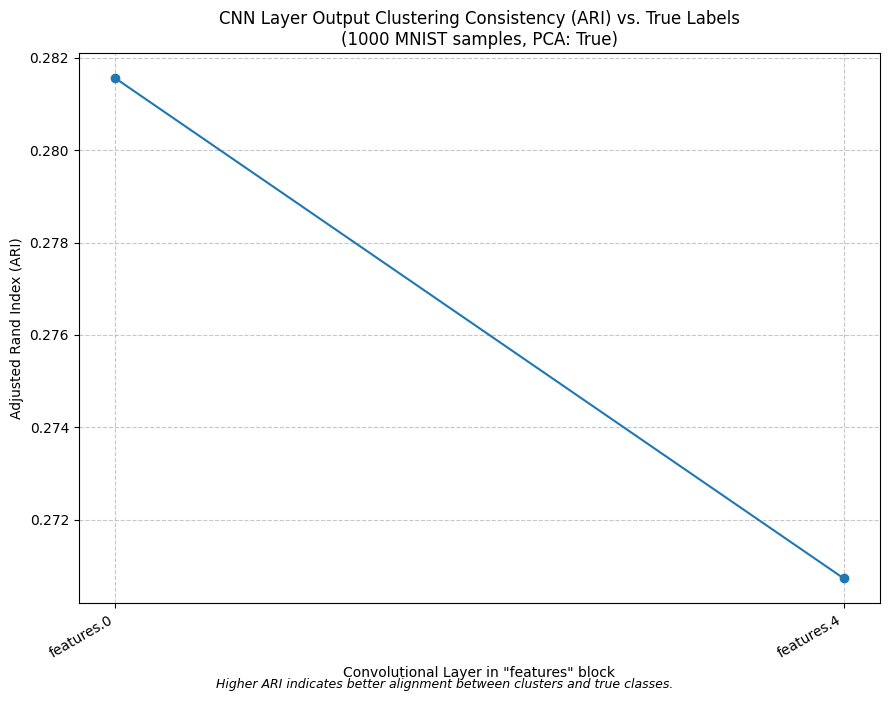

In [9]:
# --- Plotting the Trend ---
if ari_scores:
    plt.figure(figsize=(9, 7))
    plt.plot(layer_names_for_plot, ari_scores, marker="o", linestyle="-")
    plt.title(
        f"CNN Layer Output Clustering Consistency (ARI) vs. True Labels\n({NUM_SAMPLES_FOR_CLUSTERING} MNIST samples, PCA: {APPLY_PCA})"
    )
    plt.xlabel('Convolutional Layer in "features" block')
    plt.ylabel("Adjusted Rand Index (ARI)")
    plt.xticks(rotation=30, ha="right")
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.figtext(
        0.5,
        0.01,
        "Higher ARI indicates better alignment between clusters and true classes.",
        ha="center",
        fontsize=9,
        style="italic",
    )
    plt.show()
else:
    print("\nNo ARI scores were calculated, so no plot will be generated.")